In [554]:
import numpy as np
from ssid import okid, ExtractModes
from control.matlab import ss
from control.matlab import impulse as _impulse
def impulse(*args, **kwds):
    a,t = _impulse(*args, **kwds)
    return a.squeeze(),t 
from scipy import signal
from scipy.signal import dimpulse as _dimpulse
def dimpulse(*args, **kwds):
    t,a = _dimpulse(*args, **kwds)
    return [ai.squeeze() for ai in a],t 
from matplotlib import pyplot as plt
from collections import defaultdict

# 0. State Space Model Dimensions and Parameters

$$ x_{k+1} = Ax_{k} + Bu_{k} $$
$$ y_{k} = Cx_{k} + Du_{k} $$

Dimensions
- p = Number of outputs (measured dof or ndof)
- q = Number of inputs (ngdof)
- n = State dimension (2ndof)
- r = Reduced model order (choose)

Full model
- Dimensions of $\mathbf{A}$: n x n
- Dimensions of $\mathbf{B}$: n x q
- Dimensions of $\mathbf{C}$: p x n
- Dimensions of $\mathbf{D}$: p x q

Reduced model
- Dimensions of $\mathbf{\tilde{A}}$: r x r
- Dimensions of $\mathbf{\tilde{B}}$: r x q
- Dimensions of $\mathbf{\tilde{C}}$: p x r
- Dimensions of $\mathbf{\tilde{D}}$: p x q

# 1. Impulse Response Experiment

In [555]:
## Load impulse response data from hayward opensees
exp = "changecol"

input11  = np.loadtxt("./hwd_ops_impulse/"+exp+"/u1_u1.txt")
input21  = np.loadtxt("./hwd_ops_impulse/"+exp+"/u2_u1.txt")
output11 = np.loadtxt("./hwd_ops_impulse/"+exp+"/y1_u2.txt")
output21 = np.loadtxt("./hwd_ops_impulse/"+exp+"/y2_u2.txt")

input12  = np.loadtxt("./hwd_ops_impulse/"+exp+"/u1_u2.txt")
input22  = np.loadtxt("./hwd_ops_impulse/"+exp+"/u2_u2.txt")
output12 = np.loadtxt("./hwd_ops_impulse/"+exp+"/y1_u2.txt")
output22 = np.loadtxt("./hwd_ops_impulse/"+exp+"/y2_u2.txt")
nt = len(input11) # Total time
dt = 0.1 # Timestep

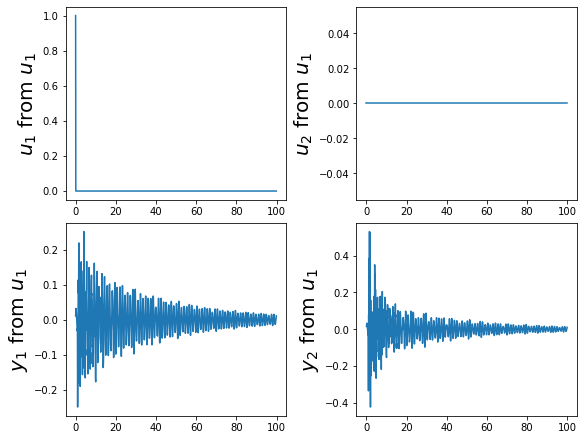

In [556]:
fig, ax = plt.subplots(2,2, figsize=(8,6), constrained_layout=True)
ax[0,0].plot(np.arange(start=0,stop=dt*nt,step=dt), input11)
ax[0,0].set_ylabel(r"$u_{1}$ from $u_{1}$", fontsize=20)
ax[0,1].plot(np.arange(start=0,stop=dt*nt,step=dt), input21)
ax[0,1].set_ylabel(r"$u_{2}$ from $u_{1}$", fontsize=20)
ax[1,0].plot(np.arange(start=0,stop=dt*nt,step=dt), output11)
ax[1,0].set_ylabel(r"$y_{1}$ from $u_{1}$", fontsize=20)
ax[1,1].plot(np.arange(start=0,stop=dt*nt,step=dt), output21)
ax[1,1].set_ylabel(r"$y_{2}$ from $u_{1}$", fontsize=20);

In [557]:
# fig, ax = plt.subplots(2,2, figsize=(8,6), constrained_layout=True)
# ax[0,0].plot(np.arange(start=0,stop=dt*nt,step=dt), input12)
# ax[0,0].set_ylabel(r"$u_{1}$ from $u_{2}$", fontsize=20)
# ax[0,1].plot(np.arange(start=0,stop=dt*nt,step=dt), input22)
# ax[0,1].set_ylabel(r"$u_{2}$ from $u_{2}$", fontsize=20)
# ax[1,0].plot(np.arange(start=0,stop=dt*nt,step=dt), output12)
# ax[1,0].set_ylabel(r"$y_{1}$ from $u_{2}$", fontsize=20)
# ax[1,1].plot(np.arange(start=0,stop=dt*nt,step=dt), output22)
# ax[1,1].set_ylabel(r"$y_{2}$ from $u_{2}$", fontsize=20);

In [558]:
# Construct output data array
yOpsImpulse = np.array([[output11,output12],[output21,output22]])
print(yOpsImpulse.shape)

(2, 2, 1000)


## Get state space model using ERA

In [559]:
## Compute ERA from impulse response
p = 2   # Number of outputs
q = 2   # Number of inputs
r = 20  # Reduced model order
nt = len(input11) # Total time
dt = 0.1 # Timestep
mco = int(np.floor((yOpsImpulse.shape[2]-1)/2)) # m_o = m_c = (nt-1)/2
Ar,Br,Cr,Dr,HSVs = okid.era(yOpsImpulse,mco,mco,p,q,r)
sysERA = ss(Ar,Br,Cr,Dr,dt)
sysERA2 = signal.StateSpace(Ar,Br,Cr,Dr,dt=dt)

## Predict response from state space model

[2, 1000]
[2, 1000]


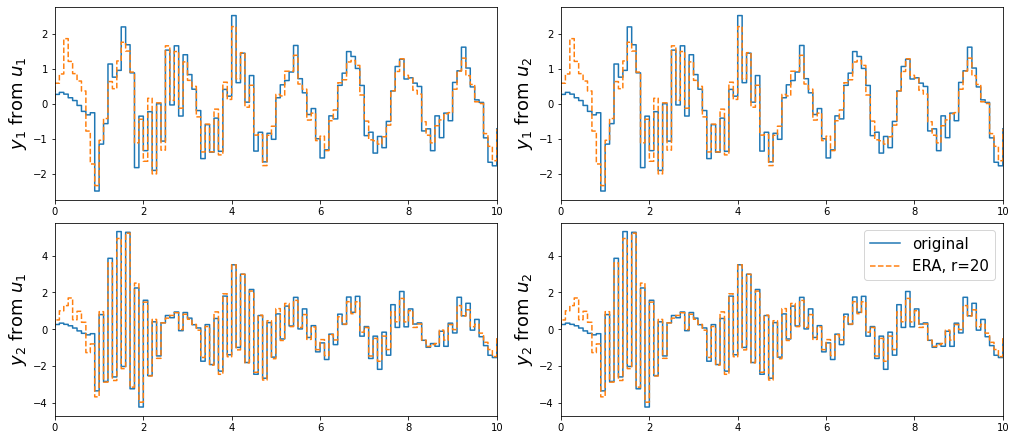

In [560]:
dt = 0.1
fig, ax = plt.subplots(2,2, figsize=(14,6), constrained_layout=True)
yERA = np.zeros((1000,p,q))
for i in range(q):
    yERA[:,:,i],times = impulse(sysERA,np.arange(start=0,stop=100,step=dt),input=i)
    print([len(a) for a in dimpulse(sysERA2,t=np.arange(start=0,stop=100,step=dt))])
    # times,yERA[:,:,i] = dimpulse(sysERA,t=np.arange(start=0,stop=100,step=dt))[i]

ax[0,0].step(times, output11/dt, label='original')
ax[0,0].step(times,yERA[:,0,0], '--')
ax[0,0].set_ylabel(r"$y_{1}$ from $u_{1}$", fontsize=18)
ax[0,1].step(times, output12/dt, label='original')
ax[0,1].step(times,yERA[:,0,1], '--')
ax[0,1].set_ylabel(r"$y_{1}$ from $u_{2}$", fontsize=18)
ax[1,0].step(times, output21/dt, label='original')
ax[1,0].step(times,yERA[:,1,0], '--')
ax[1,0].set_ylabel(r"$y_{2}$ from $u_{1}$", fontsize=18)
ax[1,1].step(times, output22/dt, label='original')
ax[1,1].step(times,yERA[:,1,1], '--', label=f'ERA, {r=}')
ax[1,1].set_ylabel(r"$y_{2}$ from $u_{2}$", fontsize=18)
ax[1,1].legend(fontsize=15)
for axi in ax:
    for axj in axi:
        axj.set_xlim(0,10);

## Get periods and damping from state space model

In [561]:
modes = ExtractModes.modes(0.1, Ar, Cr)
n_modes = 5

ImpulsePeriods = defaultdict(dict)
ImpulsePeriods[exp] = [1/f for f in sorted([modes[str(i)]['freq'] for i in list(modes.keys())])[:n_modes]]
print('Periods:', ImpulsePeriods[exp])

for i in list(modes.keys()):
    print("Mode:", str(i))
    print("Condition Number:", modes[str(i)]['cnd'])
    print("Period:", 1/modes[str(i)]['freq'])
    print("Damping:", modes[str(i)]['damp'])
    print("Mode Shape:", modes[str(i)]['modeshape'])

Periods: [1.2778544459325352, 1.0825629399148209, 0.9994920717602482, 0.9064499017481591, 0.5023509677865482]
Mode: 1
Condition Number: 1.0075363933245411
Period: 0.47361298022000936
Damping: 0.005395613713753367
Mode Shape: [0.04730386+0.1354354j  0.04184185+0.10533865j]
Mode: 3
Condition Number: 1.0074239823556945
Period: 0.5023509677865482
Damping: 0.006766784470425217
Mode Shape: [-0.01202497+0.08926694j -0.01445922+0.09210741j]
Mode: 5
Condition Number: 1.0004472004736011
Period: 1.2778544459325352
Damping: 0.004325819081830362
Mode Shape: [-0.14361995+0.22152429j -0.12446316+0.19463077j]
Mode: 7
Condition Number: 1.0027194706877465
Period: 0.9064499017481591
Damping: 0.003907879400444416
Mode Shape: [0.03578887+0.10228007j 0.04563817+0.11603953j]
Mode: 9
Condition Number: 1.003070458748085
Period: 1.0825629399148209
Damping: 0.0025332853438717394
Mode Shape: [-0.02428083+0.01767457j -0.081622  +0.06365064j]
Mode: 11
Condition Number: 1.004804170324678
Period: 0.9994920717602482
D

## See periods

C:\Users\16507\AppData\Local\Temp/ipykernel_19444/234044020.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(np.arange(nModes+1))


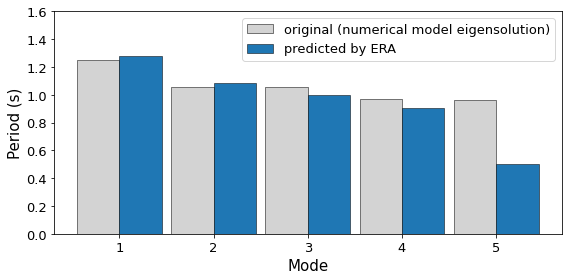

In [562]:
nModes = 5
ImpulsePeriods['ops'] = np.loadtxt("./hwd_ops_impulse/PeriodsPostG.txt")[:nModes]

fig, ax = plt.subplots(figsize=(8,4), tight_layout=True)
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
ind = np.arange(nModes)
width = 0.9/2
ax.bar(ind-0.5*width, ImpulsePeriods['ops'], width, label="original (numerical model eigensolution)", color="lightgray", edgecolor="k", linewidth=0.5)
ax.bar(ind+0.5*width, ImpulsePeriods['changecol'][:nModes], width, label="predicted by ERA", color=colors[0], edgecolor="k", linewidth=0.5)
ax.set_xticklabels(np.arange(nModes+1))
ax.set_ylim((0,1.6))
ax.set_xlabel('Mode', fontsize=15)
ax.set_ylabel('Period (s)', fontsize=15)
ax.tick_params(axis='x', labelsize=13)
ax.tick_params(axis='y', labelsize=13)
ax.legend(fontsize=13);

# 2. Real Time History Data

In [563]:
# Responses to real events

from datetime import datetime
event_dates = ['2021-06-24T00:15:00', '2021-06-29T01:29:00', '2021-07-23T15:59:00', '2021-08-03T19:52:00']

## TH Experiment: Event 2 (6/29)

In [564]:
## Load time history response data
exp = "exp2" # 6/29
i = 1
print(event_dates[i])
ops_input   = np.loadtxt("./hwd_ops_th/"+exp+"/u.txt")
window = (2089,4117)
ops_input   = ops_input[window[0]:window[1]]/386.088583
ops_output1 = np.loadtxt("./hwd_ops_th/"+exp+"/y1.txt")[window[0]:window[1]]/386.088583
ops_output2 = np.loadtxt("./hwd_ops_th/"+exp+"/y2.txt")[window[0]:window[1]]/386.088583
nt = len(ops_input)
print(nt)
dt = 0.01

2021-06-29T01:29:00
2028


In [565]:
# Construct output data array

yOpsTH = np.array([[ops_output1],[ops_output2]])
print(yOpsTH.shape)

(2, 1, 2028)


## Get state space model using ERA

In [566]:
StateSpaces = defaultdict(dict)

In [567]:
## Compute ERA from TH response
r = 20
p = 2
q = 1
print((p,q))
print(yOpsTH.shape)
mco = int(np.floor((yOpsTH.shape[2]-1)/2)) # m_o = m_c = (nt-1)/2
print(mco)
# mco=1000  # dimension of hankel matrix. smaller makes it faster.
StateSpaces[exp]['ops'] = okid.era(yOpsTH,mco,mco,p,q,r)

(2, 1)
(2, 1, 2028)
1013


In [568]:
Ar,Br,Cr,Dr,HSVs = StateSpaces[exp]['ops']
sysERA_ops = ss(Ar,Br,Cr,Dr,dt)

## Predict response from state space model

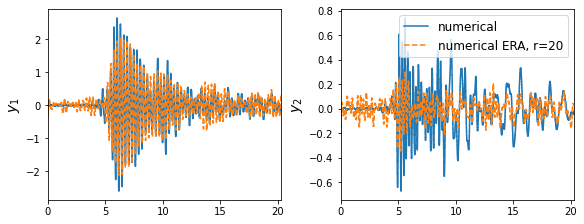

In [569]:
yERA_ops = np.zeros((nt,p,q))
for i in range(q):
    yERA_ops[:,:,i],times = impulse(sysERA_ops,np.arange(start=0,stop=nt*dt,step=dt),input=i)

fig, ax = plt.subplots(1,2, figsize=(8,3), constrained_layout=True)
ax[0].step(times, ops_output1/dt)
ax[0].step(times, yERA_ops[:,0,0], '--')
ax[0].set_ylabel(r"$y_{1}$", fontsize=14)
ax[1].step(times, ops_output2/dt, label='numerical')
ax[1].step(times, yERA_ops[:,1,0], '--', label=f'numerical ERA, {r=}')
ax[1].set_ylabel(r"$y_{2}$", fontsize=14)
ax[1].legend(fontsize=12)
for axi in ax:
    axi.set_xlim(0,nt*dt);

## Get periods from state space model

In [570]:
Periods = defaultdict(dict)

In [571]:
Ar,Br,Cr,Dr,HSVs = StateSpaces[exp]['ops']
modes_ops = ExtractModes.modes(dt, Ar, Cr)
n_modes=10
Periods[exp]['ops'] = [1/f for f in sorted([modes_ops[str(i)]['freq'] for i in list(modes.keys())])[:n_modes]]
print("Computed Periods:", Periods[exp]['ops'])
print("Computed Damping Ratios:", [d for d in sorted([modes_ops[str(i)]['damp'] for i in list(modes.keys())])[:n_modes]])

Computed Periods: [1.2306615401775989, 0.9947518896296923, 0.4086100138450741, 0.2983159173161156, 0.29214563583291525, 0.2833888246712897, 0.27281252317193677, 0.26373353064429184, 0.25413037703621877, 0.23960943546241184]
Computed Damping Ratios: [-0.006651054575823093, -0.003805233301745058, -0.00014416564279544914, 0.0012756801337510803, 0.0019384110483134363, 0.00460587606962386, 0.005023113334979754, 0.006346676460928736, 0.006789051554031659, 0.0077512999500343556]


# 3. PEER Shake Table Time History Data

## Get state space model using ERA

In [572]:
from CE58658.utilities import husid

StateSpaces = defaultdict(dict)
import json, gzip
exp = 'myshake'
wavefile = '9da16c68-aba0-3f13-b77e-9d6f3c4ee4a1_1656102779616.json.gz'
f=gzip.open(wavefile,'rb')
file_content=f.read()
raw = json.loads(file_content.decode('utf-8'))

    # data is in g - convert to m/s2  [to convert to m/s2 *9.81; to cm/s2 *981; to %g *100]
x = np.array([record['x']*9.807 for record in raw['data']])
y = np.array([record['y']*9.807 for record in raw['data']])
z = np.array([record['z']*9.807 for record in raw['data']])
    # time is in ms
t = np.array([record['ts'] for record in raw['data']])

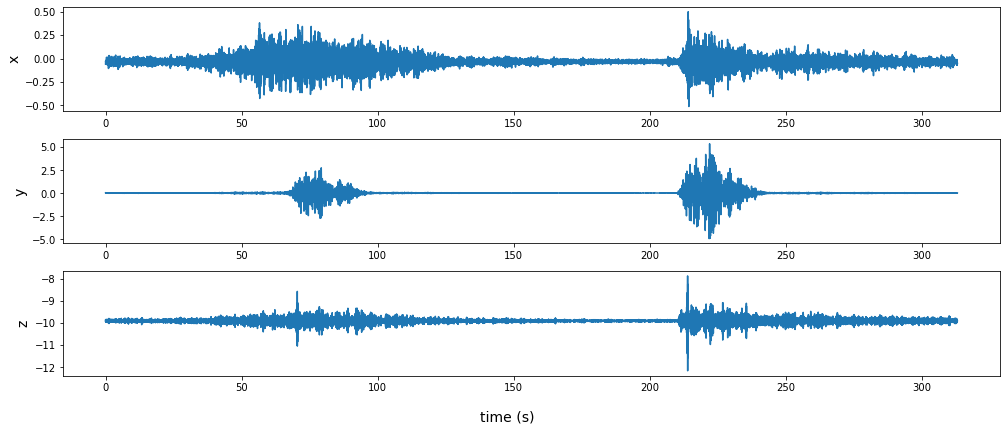

In [573]:
dt = 1/50
nt = len(x)
tf = nt*dt
t = np.arange(start=0, stop=tf, step=dt)
fig, ax = plt.subplots(3,1, figsize=(14,6), tight_layout=True)
ax[0].plot(t,x)
ax[0].set_ylabel('x', fontsize=14)
ax[1].plot(t,y)
ax[1].set_ylabel('y', fontsize=14)
ax[2].plot(t,z)
ax[2].set_ylabel('z', fontsize=14)
fig.supxlabel('time (s)', fontsize=14);

## Ambient section

972
972


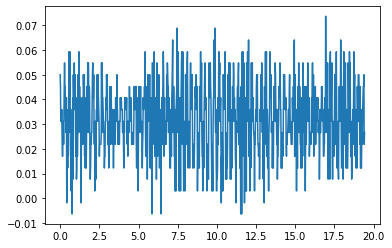

In [574]:
t1 = 1
t2 = 1000
nt = t2-t1
dt = 1/50
nf = nt*dt

y1 = y[t1:t2]
window = husid(y1, False, dt, lb=0.025, ub=0.9999)
y1 = y1[window[0]:window[1]+1]
nt = window[1]+1-window[0]
dt = 1/50
nf = nt*dt
print(nt)
print(len(y1))
t = np.arange(start=0, stop=nf, step=dt)
fig, ax = plt.subplots()
ax.plot(t, y1);
# ax.axes.get_xaxis().set_visible(False)
# ax.axes.get_yaxis().set_visible(False);

In [575]:
myshakeTH = np.array([[y1]])
print(y.shape)
r = 20
p = 1
q = 1
print((p,q))

mco = int(np.floor((myshakeTH.shape[2]-1)/2)) # m_o = m_c = (nt-1)/2
print(mco)
# mco=1000  # dimension of hankel matrix. smaller makes it faster.
StateSpaces[exp]['ambient'] = okid.era(myshakeTH,mco,mco,p,q,r)

(15647,)
(1, 1)
485


In [576]:
Ar,Br,Cr,Dr,HSVs = StateSpaces[exp]['ambient']
sysERA_ambient = ss(Ar,Br,Cr,Dr,dt)

(972,)


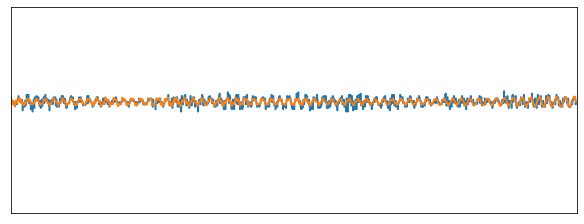

In [577]:
yERA_ambient = np.zeros((nt,q))
for i in range(q):
    yERA_ambient[:,i],times = impulse(sysERA_ambient,np.arange(start=0,stop=nt*dt,step=dt),input=i)

print(times.shape)
fig, ax = plt.subplots(1,1, figsize=(8,3), constrained_layout=True)
# ax.step(times, y*dt)
ax.step(times, y1/dt)
ax.step(times, yERA_ambient[:,0])
# ax.set_ylabel(r"$y_{1}$", fontsize=14)
# ax.legend(fontsize=12)
ax.set_xlim(0,nt*dt)
ax.set_ylim(-20,20)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False);

In [578]:
Periods = defaultdict(dict)
n_modes = int(r/2)

In [579]:
Ar,Br,Cr,Dr,HSVs = StateSpaces[exp]['ambient']
modes_ambient = ExtractModes.modes(dt, Ar, Cr)
Periods[exp]['ambient'] = [1/f for f in sorted([modes_ambient[str(i)]['freq'] for i in list(modes_ambient.keys())])[:n_modes]]
print("Computed Periods:", Periods[exp]['ambient'])
print("Computed Damping Ratios:", [d for d in sorted([modes_ambient[str(i)]['damp'] for i in list(modes_ambient.keys())])[:n_modes]])

Computed Periods: [0.3016707847079535, 0.2976205452756617, 0.097524423917285, 0.09679997146747106, 0.09310847535579159, 0.05991681193247725, 0.05946430292205289, 0.05875050151134396, 0.05739301183472315]
Computed Damping Ratios: [-0.0020416494411733786, -0.001988353838219887, -0.0004686204018623547, -0.00014182170587064395, 0.00018246830408413567, 0.00023340932447885748, 0.0006864927277698653, 0.001966093557138147, 0.002271086005409206]


## Pulse section

1393
1393


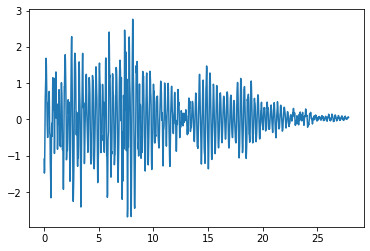

In [580]:
t1 = 3500
# t2 = 7000
t2 = 5000
nt = t2-t1
dt = 1/50
nf = nt*dt

y1 = y[t1:t2]
window = husid(y1, False, dt, lb=0.025, ub=0.9999)
y1 = y1[window[0]:window[1]+1]
nt = window[1]+1-window[0]
dt = 1/50
nf = nt*dt
print(nt)
print(len(y1))
t = np.arange(start=0, stop=nf, step=dt)
fig, ax = plt.subplots()
ax.plot(t, y1);
# ax.axes.get_xaxis().set_visible(False)
# ax.axes.get_yaxis().set_visible(False);

In [581]:
myshakeTH = np.array([[y1]])
print(y.shape)
mco = int(np.floor((myshakeTH.shape[2]-1)/2)) # m_o = m_c = (nt-1)/2
print(mco)
# mco=1000  # dimension of hankel matrix. smaller makes it faster.
StateSpaces[exp]['pulse'] = okid.era(myshakeTH,mco,mco,p,q,r)

(15647,)
696


In [582]:
Ar,Br,Cr,Dr,HSVs = StateSpaces[exp]['pulse']
sysERA_pulse = ss(Ar,Br,Cr,Dr,dt)

(1393,)


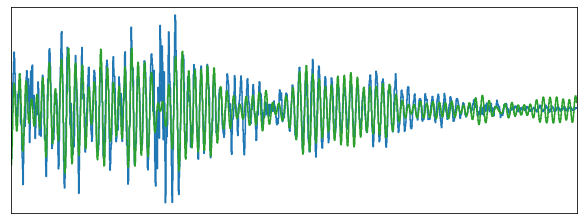

In [583]:
yERA_pulse = np.zeros((nt,q))
for i in range(q):
    yERA_pulse[:,i],times = impulse(sysERA_pulse,np.arange(start=0,stop=nt*dt,step=dt),input=i)

print(times.shape)
fig, ax = plt.subplots(1,1, figsize=(8,3), constrained_layout=True)
# ax.step(times, y*dt)
ax.step(times, y1/dt)
ax.step(times, yERA_pulse[:,0], color=colors[2])
# ax.set_ylabel(r"$y_{1}$", fontsize=14)
# ax.legend(fontsize=12)
ax.set_xlim(0,nt*dt)
ax.set_ylim(-150,150)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False);

In [584]:
Ar,Br,Cr,Dr,HSVs = StateSpaces[exp]['pulse']
modes_pulse = ExtractModes.modes(dt, Ar, Cr)
Periods[exp]['pulse'] = [1/f for f in sorted([modes_pulse[str(i)]['freq'] for i in list(modes_pulse.keys())])[:n_modes]]
print("Computed Periods:", Periods[exp]['pulse'])
print("Computed Damping Ratios:", [d for d in sorted([modes_pulse[str(i)]['damp'] for i in list(modes_pulse.keys())])[:n_modes]])

Computed Periods: [0.5073163886325065, 0.4078756003318429, 0.3762060593812695, 0.3611016149295037, 0.3445903690120687, 0.3229287847243284, 0.31661737577803856, 0.30750108328975273, 0.29513627345097365, 0.288094821582337]
Computed Damping Ratios: [0.00030012475132232903, 0.002010831820191035, 0.002394921535555249, 0.0032774191744122257, 0.003975682812528649, 0.004866452370121194, 0.005303765767131638, 0.006385070117586272, 0.009131053155084534, 0.0118463296255033]


## Period comparison

In [585]:
expected_periods = [1/3.3, 1/3.5, 1/18]

In [586]:
print(len(Periods['myshake']['ambient'][:n_modes]))
print(n_modes)

9
10


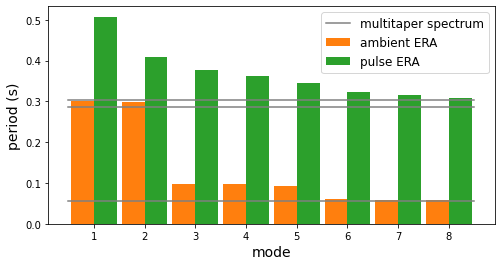

In [587]:
# n_modes = n_modes-1
n_modes = 8
fig, ax = plt.subplots(figsize=(8,4))
width=0.45
ax.bar(np.arange(1,n_modes+1)-width/2,Periods['myshake']['ambient'][:n_modes], color=colors[1], width=width, label="ambient ERA")
ax.bar(np.arange(1,n_modes+1)+width/2,Periods['myshake']['pulse'][:n_modes], color=colors[2], width=width, label="pulse ERA")
ax.plot([0.5,n_modes+0.5],[expected_periods[0]]*2, color="gray", label="multitaper spectrum")
ax.plot([0.5,n_modes+0.5],[expected_periods[1]]*2, color="gray")
ax.plot([0.5,n_modes+0.5],[expected_periods[2]]*2, color="gray")
ax.set_xticks(np.arange(1,9))
ax.set_xticklabels(np.arange(1,9))
ax.set_xlabel("mode", fontsize=14)
ax.set_ylabel("period (s)", fontsize=14)
ax.legend(fontsize=12);
# ax.axes.get_xaxis().set_visible(False)

In [588]:
np.savetxt('myshakedata.csv',np.array(y))